# Fig. 3: Shape descriptors used to measure phosphene variability

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import argus_shapes

%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-10-22 15:43:34,518 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjects = subjectdata.index.sort_values()

In [3]:
Xy = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))
Xy.drop(columns='image', inplace=True)

In [4]:
descriptors = ['area', 'orientation', 'eccentricity']
ylabels = ['area (pixels)', 'orientation (deg)', 'elongation']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

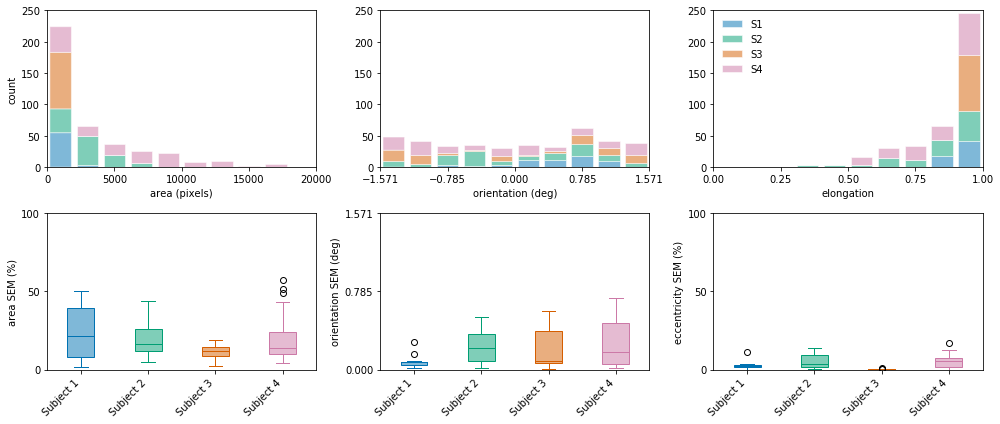

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=len(descriptors), figsize=(14, 6))

xlimits = [[0, 20000], [-np.pi/2, np.pi/2], [0, 1]]
show_medians = False

for ax, desc, color, xlim, ylabel in zip(axes[0], descriptors, colors, xlimits, ylabels):
    vals = [Xy.loc[Xy.subject == subject, desc].values for subject in subjects]
    ax.hist(vals, color=colors, label=list(subjects), range=xlim,
            edgecolor='w', linewidth=1, alpha=0.5,
            orientation='vertical', stacked=True)
    if show_medians:
        a = ax.axis()
        if desc != 'orientation':
            for v, c in zip(vals, colors):
                ax.plot([np.median(v), np.median(v)], [a[2], a[3]], '--', 
                        color=c, linewidth=2)
    ax.set_xlim(*xlim)
    ax.set_ylim(0, 250)
    ax.set_xticks(np.linspace(*xlim, num=5))
    if desc == descriptors[0]:
        ax.set_ylabel('count')
    ax.set_xlabel(ylabel)
    if desc == descriptors[-1]:
        ax.legend(loc='upper left')
        
ylimits = [[0, 100], [0, np.pi/2], [0, 100]]        
for ax, desc, ylim in zip(axes[1], descriptors, ylimits):
    for s, (subject, color) in enumerate(zip(subjects, colors)):
        vals = [data[desc].sem() / data[desc].mean() * 100
                if desc != 'orientation' else data[desc].sem()
                for _, data in Xy[Xy.subject == subject].groupby('electrode')]
        bp = ax.boxplot([vals], positions=[s], widths=0.4, patch_artist=True,
                        medianprops={'color': color}, capprops={'color': color},
                        flierprops={'color': color}, whiskerprops={'color': color})
        rgba = tuple([int(color.lstrip('#')[i:i+2], 16) / 255 for i in (0, 2 ,4)] + [0.5])
        [patch.set_facecolor(rgba) for patch in bp['boxes']]
        [patch.set_edgecolor(color) for patch in bp['boxes']]
            
    ax.set_xlim(-0.5, 3.5)
    ax.set_xticks(np.arange(len(subjects)))
    ax.set_xticklabels([s.replace("S", "Subject ") for s in subjects], ha='right', rotation=45)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=3))
    ax.set_ylabel('%s SEM (%s)' % (desc, 'deg' if desc == 'orientation' else '%'))
    
fig.tight_layout()
fig.savefig('fig3-variability.eps')

# Notes

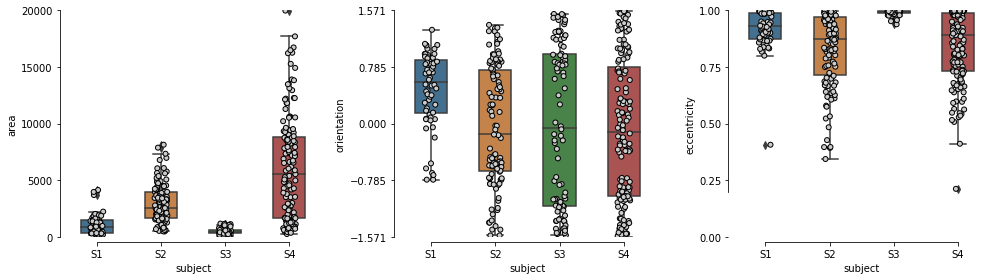

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=len(descriptors), sharex=True, figsize=(14, 4))
ylimits = [[0, 20000], [-np.pi/2, np.pi/2], [0, 1]]
for ax, desc, ylim in zip(axes, descriptors, ylimits):
    sns.boxplot(y=desc, x="subject", data=Xy.sort_values('subject').reset_index(drop=True), 
                ax=ax, width=0.5, saturation=0.5)
    sns.stripplot(y=desc, x="subject", data=Xy.sort_values('subject').reset_index(drop=True), 
                  ax=ax, color=".8", edgecolor='k', linewidth=1)
    sns.despine(offset=5, trim=True)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
fig.tight_layout()

In [7]:
n_iter = 1000
rows = []
for subject in subjects:
    for desc in descriptors:
        for dist_type in ['0_true', '1_within']:
            if dist_type == '0_true':
                sem_data = [Xy.loc[(Xy.subject == subject) & (Xy.electrode == e), desc].sem()
                            for e in Xy[Xy.subject == subject].electrode.unique()]
            elif dist_type == '1_within':
                sem_data = [Xy.loc[Xy.subject == subject, desc].sample(n=5, replace=True).sem()
                            for _ in range(n_iter)]
            else:
                raise ValueError('Unknown value "%s"' % dist_type)
            for sem in sem_data:
                rows.append({
                    'subject': subject,
                    'descriptor': desc,
                    'dist_type': dist_type,
                    'sem': float(sem)
                })
            
# Across: do only once
for desc in descriptors:
    sem_data = [Xy.loc[:, desc].sample(n=5, replace=True).sem()
                for _ in range(n_iter)]
    for subject in subjects:
        for sem in sem_data:
            rows.append({
                'subject': subject,
                'descriptor': desc,
                'dist_type': '2_across',
                'sem': float(sem)
            })

df = pd.DataFrame(rows)

In [8]:
from itertools import cycle

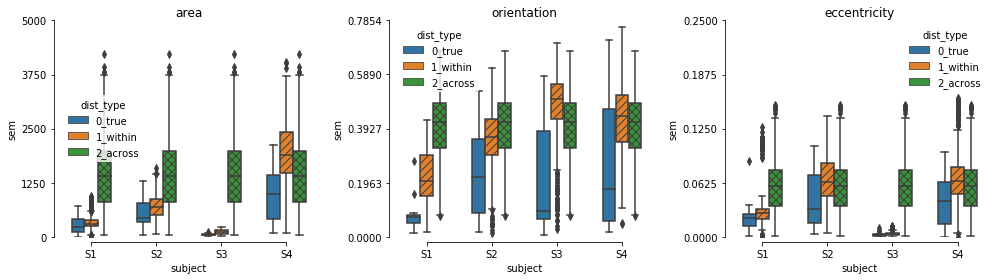

In [9]:
fig, axes = plt.subplots(ncols=len(descriptors), figsize=(14, 4))
hatches = cycle(['', '///', 'xxx'])
ylimits = [[0, 5000], [0, np.pi/4], [0, 0.25]]
for ax, desc, ylim in zip(axes, descriptors, ylimits):
    sns.boxplot(x='subject', y='sem', hue='dist_type', ax=ax, width=0.6,
                data=df[df.descriptor == desc].sort_values(['subject', 'dist_type']).reset_index(drop=True))
    for i, patch in enumerate(ax.artists):
        hatch = next(hatches)
        patch.set_hatch(hatch)
    ax.set_title(desc)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    sns.despine(ax=ax, offset=5, trim=True)
fig.tight_layout()

S1 within: RanksumsResult(statistic=-4.8376567675877098, pvalue=1.3137875610496989e-06) across: RanksumsResult(statistic=-5.7974383320752283, pvalue=6.7335528879808728e-09)
S2 within: RanksumsResult(statistic=-3.4545733136706565, pvalue=0.00055116434149674997) across: RanksumsResult(statistic=-4.5841917698635344, pvalue=4.5574582476269186e-06)
S3 within: RanksumsResult(statistic=-5.0528776735415777, pvalue=4.352026484139558e-07) across: RanksumsResult(statistic=-4.002183244546778, pvalue=6.2760660132111045e-05)
S4 within: RanksumsResult(statistic=-4.0070575493847889, pvalue=6.1479886817914905e-05) across: RanksumsResult(statistic=-3.7456856203300557, pvalue=0.00017990176929581542)


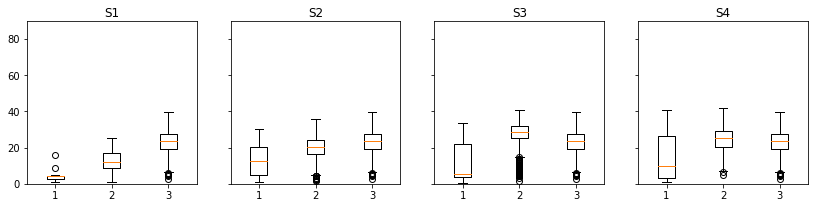

In [10]:
desc = 'orientation'
n_iter = 1000
sem_across = [Xy[desc].sample(n=5, replace=True).sem() for _ in range(n_iter)]

fig, axes = plt.subplots(ncols=len(subjects), figsize=(14, 3), sharey=True)
for ax, subject in zip(axes, subjects):
    Xys = Xy[Xy.subject == subject]
    sem_true = [Xys.loc[Xys.electrode == e, desc].sem() for e in Xys.electrode.unique()]
    sem_within = [Xys[desc].sample(n=5, replace=True).sem() for _ in range(n_iter)]
    ax.boxplot([np.rad2deg(sem_true), np.rad2deg(sem_within), np.rad2deg(sem_across)])
    ax.set_title(subject)
    ax.set_ylim(0, 90)
    print(subject, 'within:', stats.ranksums(sem_true, sem_within), 
          'across:', stats.ranksums(sem_true, sem_across))